In [1]:
from config import config
from typing import List
from augmentation import Augmentation
from aws.opensearch import OpenSearchWrapper
from aws.embedding import BedrockEmbedding

---

# Chatbot 대화

이전 대화를 기억하기 위한 memory와 검색된 결과를 prompt로 넘겨서 질문에 답변하는 챗봇을 구현합니다.

---

## 1. ChatMemory 생성

LLM 모델은 상태를 저장하지 않습니다. 대화 형태로 질의를 이어나가기 위해서는 이전 대화 내용을 프롬프트에 포함해 전달해야 합니다. 대화 기록을 저장하기 위해 LangChain의 Memory를 사용합니다.

대화 기록 저장은 인메모리 데이터 스토어인 Redis를 사용합니다.

In [2]:
from langchain.memory.chat_memory import BaseChatMemory
from langchain.memory import RedisChatMessageHistory, ConversationSummaryBufferMemory
from aws.claude import BedrockClaude


def get_redis_chat(chatId: str):
    return RedisChatMessageHistory(
            session_id=chatId,
            url=f"redis://{config.REDIS_HOST}:{config.REDIS_PORT}",
            key_prefix='chat:'
        )

def get_memory(chatId: str) -> BaseChatMemory:
    return ConversationSummaryBufferMemory(
            llm=BedrockClaude().get_chat_model(),
            max_token_limit=1000,
            memory_key="history",
            chat_memory=get_redis_chat(chatId),
            ai_prefix="Assistant",
            human_prefix="Human",
            return_messages=False
        )

def load_memory(chatId):
    memory = get_memory(chatId)
    return memory.load_memory_variables({})["history"]

## 2. Retriever 정의

In [3]:
embedding = BedrockEmbedding()

osImage = OpenSearchWrapper(
    endpoint=config.OPENSEARCH_ENDPOINT,
    index=config.OPENSEARCH_INDEX_IMAGE,
    region=config.OPENSEARCH_REGION
)

osText = OpenSearchWrapper(
    endpoint=config.OPENSEARCH_ENDPOINT,
    index=config.OPENSEARCH_INDEX_TEXT,
    region=config.OPENSEARCH_REGION
)

osImage.client.ping()

True

In [4]:
from langchain.schema import Document

def _extract_docs(docs):
    transform = lambda doc: {
        '_score': doc.get('_score', 0),
        'text': doc.get('_source', {}).get('text', ''),
        **doc.get('_source', {}).get('metadata', '{}')
    }
    return [transform(doc) for doc in docs]

def search_multimodal(text: str = None, image: str = None):
    vector = embedding.embedding_multimodal(text=text, image=image)
    return osImage.vector_search(vector=vector)
    
def search_text(text: str = None, image: str = None):
    if image:
        text = Augmentation().describe_image(image=image)
    vector = embedding.embedding_text(text=text)
    return osText.vector_search(vector=vector)

def retrieve(text: str = None, image: str = None) -> List:
    docs = []
    if image:
        docs.extend(search_multimodal(image=image))
    elif text:
        docs.extend(search_text(text=text))    
    return _extract_docs(docs)

## 3. Prompt 정의

이전 대화 내용과 검색된 문서들을 하나의 프롬프트에 넣어 생성합니다.

In [5]:
from langchain.prompts import PromptTemplate
from langchain.schema import (
    HumanMessage,
    SystemMessage,
    Document,
)

FASHION_PROMPT_TEMPLATE = """
Human would like to find fashion products, and you recommend fashion products that users want through conversations and question using only information from the search results.
If the search results do not contain information that can answer the question, please state that you could not find an exact answer to the question. Always answer in Korean.

Here are the instructions:
<instruction>
1. Analyze the user's query to understand the context and required information.
2. Generate a detailed and accurate response based on the provided sources.
3. For each sentence in the response, explain why you recommend the product. Use the format
[id]:productDisplayName
4. Ensure the response is coherent and logically structured.
</instruction>

Here are the conversation between an Assistant and a Human:
<conversations>
{conversations}
</conversations>

Here are the search results:
<search>
{search}
</search>

Here is a question from Human:
<question>
{question}
</question>
"""


def get_prompt(text: str = None, image: str = None, conversations = None, context: List[Document] = None):
    content = []

    if image:
        content.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/webp;base64,{image}",
            },
        })

    text = PromptTemplate(
            template=FASHION_PROMPT_TEMPLATE,
            input_variables=["question", "conversations", "search"]
        ).format(question=text, conversations=conversations, search=context)

    content.append({
        "type": "text",
        "text": text
    })

    messages = [
        SystemMessage(content="You are an assistant who recommends appropriate fashion products."),
        HumanMessage(
            content=content
        )
    ]

    return messages

## 4. LLM 모델 정의

Bedrock과 LangChain을 이용해 LLM 모델로 사용할 chat model을 정의합니다.

In [6]:
import asyncio
from uuid import uuid4
from aws.claude import BedrockClaude
from langchain.callbacks import AsyncIteratorCallbackHandler


# async 하게 토큰별로 출력하기 위한 callback 함수 정의
class AsyncPrintTokenCallback(AsyncIteratorCallbackHandler):
    async def on_llm_new_token(self, token: str, **kwargs) -> None:
        print(token, end='', flush=True)


async def chat(message: str):
    llm = BedrockClaude().get_chat_model(callback=AsyncPrintTokenCallback())
    task = asyncio.create_task(llm.ainvoke(input=message))
    res = await task
    print(f'\n\n========[RESULT]==========')
    print(res)
    print(f'==========================\n')
    return res

async def chat_rag(question, image=None, chatId=str(uuid4())):
    context = retrieve(text=question, image=image) # 검색
    
    # 프롬프트에 검색 결과와 대화 기록 추가
    prompt = get_prompt(
        text=question,
        image=image,
        conversations=load_memory(chatId),
        context=context
    )
    
    res = await chat(message=prompt)

    # memory에 대화 내용 저장
    memory = get_memory(chatId=chatId)
    memory.save_context(
        inputs={"human": question},
        outputs={"ai": res.content}
    )

## 5. 테스트

In [7]:
# RAG 없이 질문
_ = await chat(message='빨간색 티셔츠 추천해줘')

물론입니다. 빨간색 티셔츠는 활력 있고 눈에 띄는 색상이라 다양한 스타일에 잘 어울립니다. 몇 가지 추천해드리겠습니다.

1. 베이식 라운드 넥 티셔츠 - 단정하면서도 캐주얼한 스타일로 데님진이나 면바지와 잘 어울립니다.

2. 박시 핏 오버사이즈 티셔츠 - 루즈한 핏으로 스트리트 무드를 연출할 수 있습니다. 치노 팬츠나 조거 팬츠와 매치하면 좋습니다.

3. 그래픽 프린트 티셔츠 - 개성 있는 패턴이나 문구가 있어 포인트가 되는 아이템입니다. 심플한 아우터나 팬츠와 코디하면 좋습니다.

4. 브이넥 슬림핏 티셔츠 - 슬림한 실루엣으로 몸매 라인을 잡아줍니다. 슬림진이나 치노 팬츠와 매치하면 스타일리시한 룩이 완성됩니다.

색상과 디자인, 핏에 따라 다양한 스타일링이 가능하니 취향에 맞는 제품을 고르시면 됩니다.

========[RESULT]==========
content='물론입니다. 빨간색 티셔츠는 활력 있고 눈에 띄는 색상이라 다양한 스타일에 잘 어울립니다. 몇 가지 추천해드리겠습니다.\n\n1. 베이식 라운드 넥 티셔츠 - 단정하면서도 캐주얼한 스타일로 데님진이나 면바지와 잘 어울립니다.\n\n2. 박시 핏 오버사이즈 티셔츠 - 루즈한 핏으로 스트리트 무드를 연출할 수 있습니다. 치노 팬츠나 조거 팬츠와 매치하면 좋습니다.\n\n3. 그래픽 프린트 티셔츠 - 개성 있는 패턴이나 문구가 있어 포인트가 되는 아이템입니다. 심플한 아우터나 팬츠와 코디하면 좋습니다.\n\n4. 브이넥 슬림핏 티셔츠 - 슬림한 실루엣으로 몸매 라인을 잡아줍니다. 슬림진이나 치노 팬츠와 매치하면 스타일리시한 룩이 완성됩니다.\n\n색상과 디자인, 핏에 따라 다양한 스타일링이 가능하니 취향에 맞는 제품을 고르시면 됩니다.' additional_kwargs={'usage': {'prompt_tokens': 24, 'completion_tokens': 453, 'total_tokens': 477}, 'stop_reason': 'end_turn', 'model_id': 'anthro

In [9]:
chatId = 'sample-chat'
memory = get_memory(chatId=chatId)

await chat_rag(question='빨간색 티셔츠 추천해줘', chatId=chatId)

네, 빨간색 티셔츠를 추천해 드리겠습니다.

[10866]: Wrangler Men Motor Rider Red T-Shirts
이 티셔츠는 라운드 넥 디자인에 오토바이 그래픽 프린트가 있어 캐주얼하면서도 스타일리시한 룩을 연출할 수 있습니다. 면 소재로 제작되어 편안한 착용감을 자랑합니다.

[12908]: Spykar Men Check Red Shirts  
가을 시즌에 잘 어울리는 체크 무늬 셔츠입니다. 빨간색과 검은색 체크 패턴이 매력적이며, 부드러운 소재와 편안한 착용감을 지녔습니다. 캐주얼한 스타일에 세련미를 더해줄 셔츠입니다.

[2689]: Inkfruit Women Happy Dolphin Purple T-shirt
보라색 배경에 파란색과 빨간색 돌고래 디자인이 프린트된 여성용 캐주얼 티셔츠입니다. 면 소재로 만들어져 부드럽고 착용감이 좋습니다.

[57029]: Forever New Women Pink Top  
빨간색 브라우스에 프릴 장식과 레이스업 디테일이 있어 여성스러운 룩을 연출하기에 좋습니다. 가벼운 소재감으로 활동성도 좋습니다.

제가 추천한 제품들 중에서 취향에 맞는 스타일의 빨간색 상의를 고르시면 되겠습니다.

========[RESULT]==========
content='네, 빨간색 티셔츠를 추천해 드리겠습니다.\n\n[10866]: Wrangler Men Motor Rider Red T-Shirts\n이 티셔츠는 라운드 넥 디자인에 오토바이 그래픽 프린트가 있어 캐주얼하면서도 스타일리시한 룩을 연출할 수 있습니다. 면 소재로 제작되어 편안한 착용감을 자랑합니다.\n\n[12908]: Spykar Men Check Red Shirts  \n가을 시즌에 잘 어울리는 체크 무늬 셔츠입니다. 빨간색과 검은색 체크 패턴이 매력적이며, 부드러운 소재와 편안한 착용감을 지녔습니다. 캐주얼한 스타일에 세련미를 더해줄 셔츠입니다.\n\n[2689]: Inkfruit Women Happy Dolphin Purple T-shirt\n보라색 배


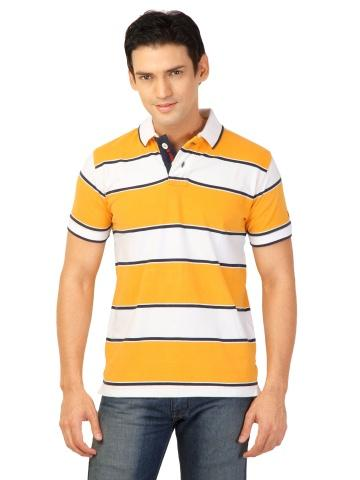

제공된 이미지는 노란색과 흰색 스트라이프 무늬의 반팔 폴로 셔츠를 착용한 남성 모델을 보여주고 있습니다. 검색 결과에는 비슷한 스타일의 폴로 셔츠가 몇 가지 있습니다. 

[11743]: Lee Men Green Polo Tshirts
이 폴로 셔츠는 올리브 그린 색상에 연한 그린 스트라이프 무늬가 있어 이미지의 제품과 비슷한 스타일입니다. 면 소재로 제작되어 편안한 착용감을 자랑합니다.

[5719]: Basics Men Green Academy Football League T-shirt  
녹색 바탕에 흰색과 갈색 스트라이프 무늬가 있는 폴로 셔츠입니다. 이미지 제품과 유사한 스트라이프 패턴을 가지고 있으며, 캐주얼한 스타일의 여름 셔츠입니다.

[19594]: United Colors of Benetton Men Striped Black TShirt
회색과 검정색 스트라이프 패턴의 긴팔 폴로 셔츠로, 이미지 제품과 비슷한 스트라이프 디자인을 가지고 있습니다. 

위 제품들이 이미지의 노란색 스트라이프 폴로 셔츠와 가장 유사한 스타일을 보여주고 있습니다. 취향에 맞는 색상과 디자인을 고르시면 되겠습니다.

========[RESULT]==========
content='제공된 이미지는 노란색과 흰색 스트라이프 무늬의 반팔 폴로 셔츠를 착용한 남성 모델을 보여주고 있습니다. 검색 결과에는 비슷한 스타일의 폴로 셔츠가 몇 가지 있습니다. \n\n[11743]: Lee Men Green Polo Tshirts\n이 폴로 셔츠는 올리브 그린 색상에 연한 그린 스트라이프 무늬가 있어 이미지의 제품과 비슷한 스타일입니다. 면 소재로 제작되어 편안한 착용감을 자랑합니다.\n\n[5719]: Basics Men Green Academy Football League T-shirt  \n녹색 바탕에 흰색과 갈색 스트라이프 무늬가 있는 폴로 셔츠입니다. 이미지 제품과 유사한 스트라이프 패턴을 가지고 있으며, 캐주얼한 스타일의 여름 셔츠입니다.\n\n[19594]: United

In [10]:
from dataloader import get_item
from utils import encode_image_base64
from notebook_utils import display_image

item = get_item('12206')
image = encode_image_base64(item['thumbnail'])
display_image(image)
await chat_rag(question='이 이미지랑 비슷한 제품', image=image, chatId=chatId)